# Toxic Comment Text Classification 
## BT4222 | Group 5
- Chen Yiwen (A0159857H)
- Dong Han (A0162689M)
- Ma Tianran (A0157706Y)
- Tanya Ramesh (A0162732J)


Our group is working towards a model trained using the abundant online comments, to target at future possible abusive comments. 

The challenge we have is to build a comprehensive multi-headed model which is capable of classifying if the given input is associated with different types of toxicity such as toxic, threats, obscenity, insults, and identity-based hate. 

Instead of predicting the classes directly, we decided to predict the probability of each type of toxicity for the input comment. This enables us to set a threshold on deciding if the comment is toxic or not. 

### There will be 5 parts of this notebook: 
- Data Preprocessing
- Logistic Regression Model
- Multinomial Naive Bayes Model
- LSTM Model
- Test on Reddit Dataset 

In [1]:
#Import required packages and libraries 
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from textblob import TextBlob
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from scipy.sparse import hstack


from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras import initializers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras import regularizers

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB


Using TensorFlow backend.
/Users/matianran/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/matianran/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/matianran/anaconda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/matianran/anaconda/lib/python3.6/site-pa

## 1. Data Preprocessing

In [2]:
#read Training Data
df_train = pd.read_csv("train.csv")
df_train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [3]:
#ready reddit data
df_reddit = pd.read_csv('reddit_comments.csv')
df_reddit.head(10)

,Unnamed: 0,Comments,Submission_ID,Is_Submitter,Author,Time,Upvotes
0,0,Welcome to r/Coronavirus! We have a very speci...,t3_fe9i00,True,AutoModerator,1.583476e+09,1
1,1,I was in Waikiki where two confirmed cases wer...,t3_fe9i00,False,MaplewoodDUDE,1.583478e+09,314
2,2,I'm a student at Lake Washington School Distrc...,t3_fe9i00,False,AutumnSolace1999,1.583476e+09,454
3,3,will disney close it’s us parks?,t3_fe9i00,False,morgandiprima,1.583478e+09,45
4,4,I think we will reach 100k cases today. We hav...,t3_fe9i00,False,Nice_Pro_Clicker,1.583477e+09,117
5,5,Paramedic here. We could see serious staffing ...,t3_fe9i00,False,Blueiguana1100,1.583477e+09,110
6,6,The people who are not taking this situation s...,t3_fe9i00,False,itsnotaboutewe,1.583480e+09,159
7,7,What should I do:\n\nHuge family reunion plann...,t3_fe9i00,False,Boobznow,1.583479e+09,99
8,8,[please boost this press conference ](https://...,t3_fe9i00,False,TapatioPapi,1.583484e+09,67
9,9,Here's a real nice story about the gentleman w...,t3_fe9i00,False,atlasrecrd,1.583479e+09,34


In [4]:
##################
# Text Cleaning  #
##################

# Spelling correction is based on Peter Norvig’s “How to Write a Spelling Corrector” as implemented in the pattern 
# library. It is about 70% accurate 
def spelling_correction(row):
    b = TextBlob(row)
#     print(b)
    return b.correct()


def clean_text(text, remove_stopwords = False):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()

    # Replace contractions with their longer forms 
    # A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    contractions = { "ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because",
    "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not",
    "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
    "he'd've": "he would have", "he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will", "how's": "how is",
    "i'd": "i would", "i'll": "i will", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'll": "it will", 
    "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not",
    "must've": "must have", "mustn't": "must not", "needn't": "need not", "oughtn't": "ought not", "shan't": "shall not",
    "sha'n't": "shall not", "she'd": "she would", "she'll": "she will", "she's": "she is", "should've": "should have",
    "shouldn't": "should not","that'd": "that would", "that's": "that is", "there'd": "there had", "there's": "there is", "they'd": "they would",
    "they'll": "they will", "they're": "they are", "they've": "they have", "wasn't": "was not", "we'd": "we would", "we'll": "we will",
    "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what're": "what are", "what's": "what is",
    "what've": "what have", "where'd": "where did", "where's": "where is", "who'll": "who will", "who's": "who is", "won't": "will not",
    "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are"}

    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Clean the text
    # reference: https://medium.com/@sabber/classifying-yelp-review-comments-using-lstm-and-word-embeddings-part-1-eb2275e4066b
    # test site: https://regex101.com/
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)   
    text = re.sub(r"\s{2,}", " ", text)
    
    #remove twitter @username and html link 
    test = re.sub(r"@\w+", " ", text)
    test = re.sub(r"https\w+", " ", text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)
    
    return text


def text_preprocessing(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: clean_text(x))
    
    # spelling correction is extremely slow......took me around 45 mins to run
#     df[column_name] = df[column_name].progress_apply(lambda x: spelling_correction(x))
    
    return df


###########################
# Polarity & Subjectivity #
###########################  

def get_Polarity(row):
    blob = TextBlob(row)
    Sentiment = blob.sentiment
    return Sentiment.polarity

def get_Subjectivity(row):
    blob = TextBlob(row)
    Sentiment = blob.sentiment
    return Sentiment.subjectivity


def text_sentiment_preprocessing(df, column_name):
    #slow - xx mins
    df['Text_Polarity'] = df[column_name].apply(lambda x: get_Polarity(x))
    #
    df['Text_Subjectivity'] = df[column_name].apply(lambda y: get_Subjectivity(y))
    
    return df
    

In [5]:
print("Pre-processing training data - This will take some time")
text_preprocessing(df_train, 'comment_text')
text_sentiment_preprocessing(df_train, 'comment_text')

print("Pre-processing Reddit data - This will take some time")
text_preprocessing(df_train, 'comment_text')
text_sentiment_preprocessing(df_reddit, 'Comments')
df_reddit = df_reddit[['Comments', 'Submission_ID', 'Is_Submitter', 'Author','Time', 'Upvotes',
                       'Text_Polarity', 'Text_Subjectivity']]

Pre-processing training data - This will take some time
Pre-processing Reddit data - This will take some time


In [6]:
labels = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']
X = df_train["comment_text"]
y = df_train[labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2020)

## 2. Logistic Regression Model

In [7]:
#Vectorization of text for Logreg Model
vect_logreg = CountVectorizer(lowercase=False,ngram_range=(1, 2))
X_train_dtm = vect_logreg.fit_transform(X_train)
X_test_dtm = vect_logreg.transform(X_test)

logreg = LogisticRegression(C=12.0)

In [8]:
prob_result = pd.DataFrame(columns = labels)
for label in labels:
  print('Processing {}'.format(label))
  train_class = y_train[label]
  test_class = y_test[label]
  logreg.fit(X_train_dtm, train_class)
  
  # compute the training accuracy
  y_train_pred = logreg.predict(X_train_dtm)
  y_test_pred = logreg.predict(X_test_dtm)
  print('Training accuracy is {}'.format(accuracy_score(train_class, y_train_pred)))
  print('Test accuracy is {}'.format(accuracy_score(test_class, y_test_pred)))
  
  # compute the predicted probabilities for X_test_dtm
  test_y_prob = logreg.predict_proba(X_test_dtm)[:,1]
  prob_result[label] = test_y_prob

  #plot ROC AUC 
  frp,trp,thres = roc_curve(y_test[label],test_y_prob)
  auc_val =auc(frp,trp)
  print('AUC Score is {}'.format(auc_val))

Processing obscene


/Users/matianran/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/matianran/anaconda/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Training accuracy is 0.9717157706512475
Test accuracy is 0.9686912490913193
[2.19593689e-02 2.88523602e-02 2.34344210e-06 ... 2.86300092e-02
 1.62057066e-03 1.70786437e-02]
AUC Score is 0.9602676800009186
Processing insult
Training accuracy is 0.9641371012216113
Test accuracy is 0.9632516982929336
[1.58460644e-02 3.97514768e-02 6.83525511e-08 ... 2.75385187e-02
 1.63701026e-03 1.31110549e-02]
AUC Score is 0.9456756910568773
Processing toxic
Training accuracy is 0.957394007252795
Test accuracy is 0.9484872032687439
[2.33293510e-02 4.48076762e-02 1.21089809e-09 ... 1.48895820e-02
 2.14870574e-03 1.75738366e-02]
AUC Score is 0.9515814155602742
Processing severe_toxic
Training accuracy is 0.9913100152074734
Test accuracy is 0.9897475747624896
[4.31060723e-03 8.44677409e-03 3.78169348e-08 ... 4.45409541e-03
 1.04654322e-04 2.24689038e-03]
AUC Score is 0.9511768395598934
Processing identity_hate
Training accuracy is 0.9917612259563161
Test accuracy is 0.9905747875567142
[4.46693767e-03 8.256

In [9]:
#fit logreg vectorizer to the entire training dataset 
X_dtm = vect_logreg.fit_transform(X)

## 3. Multinomial Naive Bayes Model

In [18]:
train_com = df_train.comment_text

word_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_features=10000,
    sublinear_tf = True,
    token_pattern=r'\w{1,}',
    strip_accents='unicode')     
word_vectorizer.fit(train_com)
train_word_features = word_vectorizer.transform(train_com)

char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    max_features=50000,
    strip_accents='unicode')
char_vectorizer.fit(train_com)
train_char_features = char_vectorizer.transform(train_com)

train_features = hstack([train_char_features, train_word_features])


In [19]:
scores = []
for i in labels:
    train_target = df_train[i]
    classifier = MultinomialNB()
    cv_score_auc = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='roc_auc'))
    scores.append(cv_score_auc)
    print('AUC CV score for class {} is {}'.format(i, cv_score_auc))
    
    cv_score_acc = np.mean(cross_val_score(classifier, train_features, train_target, cv=3, scoring='accuracy'))
    scores.append(cv_score_acc)
    print('Accuracy CV score for class {} is {}'.format(i, cv_score_acc))

AUC CV score for class obscene is 0.9654996509233292
Accuracy CV score for class obscene is 0.9622926502597697
AUC CV score for class insult is 0.9641766412130134
Accuracy CV score for class insult is 0.9585325566308388
AUC CV score for class toxic is 0.9559249409835134
Accuracy CV score for class toxic is 0.939844950613152
AUC CV score for class severe_toxic is 0.9741089481450566
Accuracy CV score for class severe_toxic is 0.9847904739185814
AUC CV score for class identity_hate is 0.9376362380346741
Accuracy CV score for class identity_hate is 0.9858746285400337
AUC CV score for class threat is 0.9046999120841743
Accuracy CV score for class threat is 0.9964091221936039


## 3. LSTM

In [32]:
# Find the number of times each word was used and the size of the vocabulary
def word_count(df, column_name):
    word_counts = {}

    for comment in df[column_name]:
        for word in comment.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
                
    greater_than_5 = sum(1 for i in word_counts.values() if i >= 5)
    greater_than_10 = sum(1 for i in word_counts.values() if i >= 10)
                
    return (len(word_counts), greater_than_5, greater_than_10)

print("Size of Training Vocabulary:", word_count(df_train, 'comment_text')[0])
print("Size of Reddit Vocabulary:", word_count(df_reddit, 'Comments')[0], '\n')

print("Words of Training Vocabulary appear > 5 times:", word_count(df_train, 'comment_text')[1])
print("Words of Reddit Vocabulary appear > 5 times:", word_count(df_reddit, 'Comments')[1], '\n')

print("Words of Training Vocabulary appear > 10 times:", word_count(df_train, 'comment_text')[2])
print("Words of Reddit Vocabulary appear > 10 times:", word_count(df_reddit, 'Comments')[2])

    

Size of Training Vocabulary: 187531
Size of Reddit Vocabulary: 35441 

Words of Training Vocabulary appear > 5 times: 43394
Words of Reddit Vocabulary appear > 5 times: 6178 

Words of Training Vocabulary appear > 10 times: 27170
Words of Reddit Vocabulary appear > 10 times: 3524


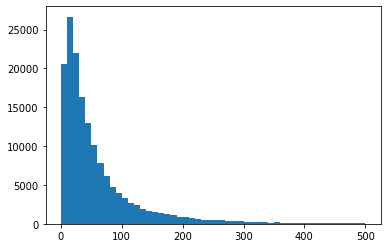

In [33]:
# Tokenize the comments 

max_features = 27170
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(df_train["comment_text"]))
list_tokenized_train = tokenizer.texts_to_sequences(df_train["comment_text"])
list_tokenized_reddit = tokenizer.texts_to_sequences(df_reddit["Comments"])

# Check the distribution of the number of words in the comments
WordCount = [len(comment) for comment in list_tokenized_train]

plt.hist(WordCount,bins = np.arange(0,510,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

In [34]:
#Therefore, define maxlen = 200 as most of the comments has <=150 tokenized words
max_features=27170
maxlen=200

In [35]:
from keras.preprocessing import text, sequence
X_train = list_tokenized_train
X_test_reddit = list_tokenized_reddit 

x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test_reddit = sequence.pad_sequences(X_test_reddit, maxlen=maxlen)

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = df_train[list_classes].values
y_train = np.array(y_train)

x_train_train, x_train_val, y_train_train, y_train_val = train_test_split(x_train, y_train, test_size=0.2)


In [36]:
print(x_train.shape)
print(x_test_reddit.shape)
print(y_train.shape)

print('For validation purpose')
print(x_train_train.shape)
print(x_train_val.shape)

(159571, 200)
(11725, 200)
(159571, 6)
For validation purpose
(127656, 200)
(31915, 200)


In [39]:
# Load GloVe's embeddings
glove6b100d = 'glove.6B.100d.txt'

embed_size=100

embeddings_index = {}
with open(glove6b100d, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 400000


In [40]:
word_index = tokenizer.word_index
#prepare embedding matrix
num_words = min(max_features, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embed_size))
for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [41]:
def train_model(Optimizer, X_train, y_train, X_val, y_val):
    
    model = Sequential()
    
    model.add(Embedding(max_features, embed_size, weights = [embedding_matrix]))
   
    model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(6,  activation="sigmoid"))
    
    model.compile(loss='mean_squared_error', optimizer=Optimizer, metrics=['accuracy'])
    
    scores = model.fit(X_train, y_train, batch_size=128, epochs=3, validation_data=(X_val, y_val))
    
    return scores, model

RMSprop_score, RMSprop_model = train_model(Optimizer = 'adam', \
                                           X_train=x_train_train, y_train=y_train_train, \
                                           X_val=x_train_val, y_val=y_train_val)




Train on 127656 samples, validate on 31915 samples
Epoch 1/3
127656/127656 [==============================] - 432s 3ms/step - loss: 0.0249 - acc: 0.6112 - val_loss: 0.0144 - val_acc: 0.9938
Epoch 2/3
127656/127656 [==============================] - 417s 3ms/step - loss: 0.0142 - acc: 0.8087 - val_loss: 0.0129 - val_acc: 0.9938
Epoch 3/3
127656/127656 [==============================] - 405s 3ms/step - loss: 0.0129 - acc: 0.8377 - val_loss: 0.0127 - val_acc: 0.9938


In [44]:
from sklearn.metrics import roc_auc_score


y_train_val_pred = RMSprop_model.predict(x_train_val)
auc = roc_auc_score(y_train_val, y_train_val_pred)
print("Total roc auc score = {0:0.4f}".format(auc))

Total roc auc score = 0.9781


In [45]:
# Model Building
def train_model(Optimizer, X_train, y_train):
      
    model = Sequential()
    
    model.add(Embedding(max_features, embed_size, weights = [embedding_matrix]))
   
    model.add(LSTM(units=50, dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(25, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(6,  activation="sigmoid"))
    
    model.compile(loss='mean_squared_error', optimizer=Optimizer, metrics=['accuracy'])
    scores = model.fit(X_train, y_train, batch_size=128, epochs=3, verbose = 2)
    return scores, model

score, model = train_model(Optimizer = 'adam', X_train=x_train , y_train=y_train)

Epoch 1/3
 - 499s - loss: 0.0252 - acc: 0.7397
Epoch 2/3
 - 1144s - loss: 0.0138 - acc: 0.9619
Epoch 3/3
 - 553s - loss: 0.0127 - acc: 0.9839


## 4. Test on Reddit Dataset

### Logistic Regression Results

In [17]:
#generate reddit results
reddit_dtm = vect_logreg.transform(df_reddit['Comments'])
logreg_reddit_results = pd.DataFrame(columns = labels)

for label in labels:
    print(label)
    train_class = y[label]
    logreg.fit(X_dtm, train_class)
    predicted_result = logreg.predict_proba(reddit_dtm)[:,1]
    logreg_reddit_results[label] = predicted_result


obscene
insult
toxic
severe_toxic
identity_hate
threat


### Multinomial NB results

In [24]:
reddit_com = df_reddit.Comments
reddit_word_features = word_vectorizer.transform(reddit_com)
reddit_char_features = char_vectorizer.transform(reddit_com)
reddit_features = hstack([reddit_word_features, reddit_char_features])

nb_reddit_results = pd.DataFrame(columns = labels)
for i in labels:
    train_target = df_train[i]
    classifier.fit(train_features, train_target)
    nb_reddit_results[i] = classifier.predict_proba(reddit_features)[:,1]
    

### LSTM Results

In [46]:
reddit_prediction = model.predict(x_test_reddit)
lstm_reddit_results = pd.DataFrame(data=reddit_prediction, columns=list_classes)

### Average the results of outputs from 3 models 

In [43]:
final_reddit_results = pd.DataFrame(columns=labels)
final_reddit_results['comment_text'] = df_reddit.Comments
for i in labels:
    final_reddit_results[i] = (logreg_reddit_results[i] + lstm_reddit_results[i] +nb_reddit_results[i])/3

In [44]:
final_reddit_results

,obscene,insult,toxic,severe_toxic,identity_hate,threat,comment_text
0,0.303851,0.322770,0.106949,0.333375,0.333400,0.333338,Welcome to r/Coronavirus! We have a very speci...
1,0.137598,0.180709,0.009999,0.333350,0.333559,0.333357,I was in Waikiki where two confirmed cases wer...
2,0.324192,0.328475,0.131185,0.333334,0.333368,0.333356,I'm a student at Lake Washington School Distrc...
3,0.149040,0.121289,0.144809,0.188171,0.158812,0.160980,will disney close it’s us parks?
4,0.187096,0.216534,0.058355,0.334009,0.335247,0.333425,I think we will reach 100k cases today. We hav...
...,...,...,...,...,...,...,...
11720,0.231517,0.249913,0.225688,0.335869,0.343191,0.333787,It hasn’t. It’s been established that false ne...
11721,0.038381,0.038719,0.054186,0.135140,0.151499,0.163025,its gonne happen in europe to lol
11722,0.107698,0.159176,0.166796,0.336016,0.338125,0.332830,"Not even ""sick"" per se, just still shedding vi..."
11723,0.213627,0.224200,0.049032,0.334114,0.334768,0.333473,they don't know if it's misdiagnosis/false neg...


In [45]:
final_reddit_results.to_csv('final_reddit_result.csv')